In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn.functional as F


def visualize_attention_weights(batch_size, num_heads, attn_weights):
    # Visualize attention weights
    fig, axs = plt.subplots(nrows=batch_size, ncols=num_heads, figsize=(16, 16))

    for batch_idx in range(batch_size):
        for head_idx in range(num_heads):
            ax = axs[batch_idx, head_idx] if batch_size > 1 else axs[head_idx]
            ax.matshow(attn_weights[batch_idx, head_idx].detach().numpy(), cmap='YlOrRd')

            for (i, j), val in np.ndenumerate(attn_weights[batch_idx, head_idx].detach().numpy()):
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)

            ax.set_xlabel(f'Head {head_idx + 1}')
            if head_idx == 0:
                ax.set_ylabel(f'Batch {batch_idx + 1}')

    plt.tight_layout()
    plt.show()



def visualize_luong_attention(hidden, encoder_outputs, attn_weights):
    batch_size = hidden.size(0)
    max_length = encoder_outputs.size(1)

    # Normalize attention weights for better visualization
    attn_weights = F.softmax(attn_weights, dim=2)

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=batch_size, ncols=3, figsize=(8, 8))

    for batch_idx in range(batch_size):
        # Plot hidden state
        axs[batch_idx, 0].imshow(hidden[batch_idx].detach().numpy().T, cmap='Blues', interpolation='nearest')
        axs[batch_idx, 0].set_title('Hidden State')
        axs[batch_idx, 0].set_xlabel('Hidden Units')
        axs[batch_idx, 0].set_ylabel('Batch')

        # Plot encoder outputs
        axs[batch_idx, 1].imshow(encoder_outputs[batch_idx].detach().numpy().T, cmap='Greens', interpolation='nearest')
        axs[batch_idx, 1].set_title('Encoder Outputs')
        axs[batch_idx, 1].set_xlabel('Time Step')
        axs[batch_idx, 1].set_ylabel('Hidden Units')

        # Plot attention weights
        axs[batch_idx, 2].imshow(attn_weights[batch_idx].detach().numpy(), cmap='Reds', interpolation='nearest')
        axs[batch_idx, 2].set_title('Attention Weights')
        axs[batch_idx, 2].set_xlabel('Time Step')
        axs[batch_idx, 2].set_ylabel('Hidden State')

    plt.tight_layout()
    plt.show()

def visualize_attention_with_input_output(x, atten_output, attn_weights):
    batch_size, seq_len, _ = x.size()
    _, _, output_seq_len, input_seq_len = attn_weights.size()

    fig, axs = plt.subplots(nrows=batch_size, ncols=2, figsize=(8,8))

    for batch_idx in range(batch_size):
        # Plot input sequence
        axs[batch_idx, 0].imshow(x[batch_idx].T, cmap='Blues', interpolation='nearest')
        axs[batch_idx, 0].set_title('Input Sequence')
        axs[batch_idx, 0].set_xlabel('Input Seq Pos')
        axs[batch_idx, 0].set_ylabel('Features')

        # Plot attention weights
        axs[batch_idx, 1].imshow(attn_weights[batch_idx, 0].detach().numpy(), cmap='Reds', interpolation='nearest')
        axs[batch_idx, 1].set_title('Attention Weights')
        axs[batch_idx, 1].set_xlabel('Output Seq Pos')
        axs[batch_idx, 1].set_ylabel('Input Seq Pos')

    plt.tight_layout()
    plt.show()


# Luong Attention:
This is a simpler version of the Bahdanau attention. It uses dot product or concatenation to calculate the alignment score and applies softmax to obtain the attention weights.

Decoder Hidden State Shape:  torch.Size([2, 1, 16])
Encoder Output Shape:  torch.Size([2, 10, 16])
Attention Weights Shape: torch.Size([10, 1, 2])


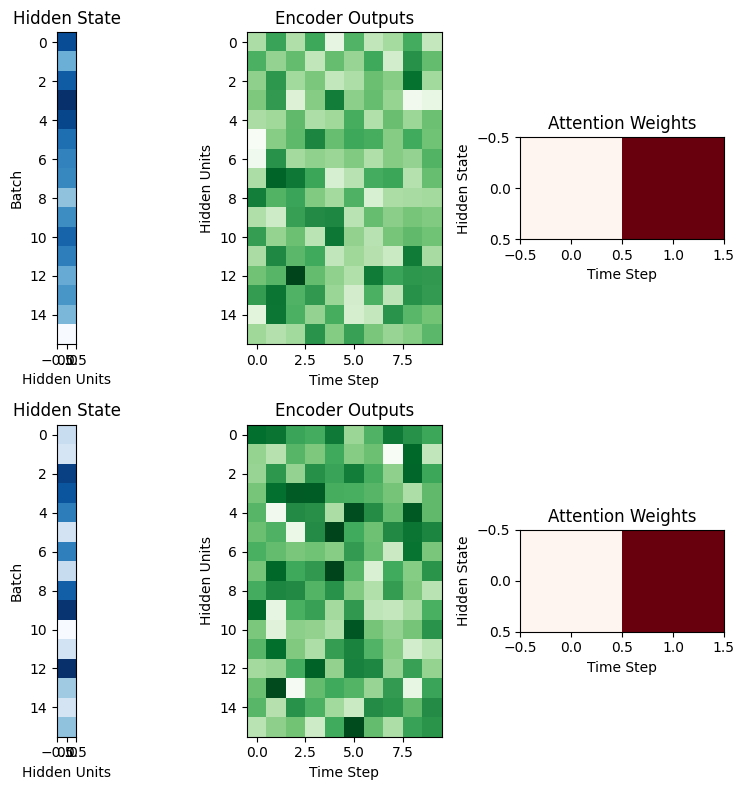

In [82]:
import torch
import torch.nn as nn

class LuongAttention(nn.Module):
    def __init__(self, hidden_size, method='dot'):
        super(LuongAttention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return nn.functional.softmax(attn_energies, dim=1).unsqueeze(1)

# Example usage
batch_size = 2
max_length = 10
hidden_size = 16

# Create dummy input tensors
hidden = torch.randn(batch_size, 1, hidden_size)  # Assume decoder hidden state
encoder_outputs = torch.randn(batch_size, max_length, hidden_size)  # Assume encoder outputs

# Create an instance of LuongAttention
luong_attn = LuongAttention(hidden_size, method='dot')

# Apply the Luong attention
attn_weights = luong_attn(hidden, encoder_outputs)

print("Decoder Hidden State Shape: ",hidden.shape)
print("Encoder Output Shape: ",encoder_outputs.shape)
print("Attention Weights Shape:", attn_weights.shape)

visualize_luong_attention(hidden, encoder_outputs, attn_weights)

#Multi-Head Attention:
This is an extension of the scaled dot-product attention, also proposed in the Transformer model. It uses multiple attention heads to attend to different positions of the input simultaneously, allowing the model to capture more complex dependencies.


    Input(x) :
(batch_size, seq_len, input_dim)

    Query(q),Key(k),Value(v) Projections:
(batch_size, seq_len, embed_dim).

    Split into Multiple Heads:
    q, k, and v are reshaped to
(batch_size, num_heads, seq_len, head_dim).

    Attention Scores/Weights:
    attn_weights has the same dimensions as attn_scores as attn_weights = softmx(attn_scores)
  (batch_size, num_heads, query_len, key_len).

    Attention Output:
    attn_output has dimensions
    
  (batch_size, num_heads, query_len, head_dim).


    Concatenate Heads and Apply Output Projection:

    attn_output is first reshaped to
  (batch_size, query_len, embed_dim).

    after applying the output projection.output has dimensions
  (batch_size, query_len, input_dim)


    

Input shape: torch.Size([2, 4, 16])
Attention Output shape: torch.Size([2, 4, 16])
Attention Weight shape: torch.Size([2, 4, 4, 4])


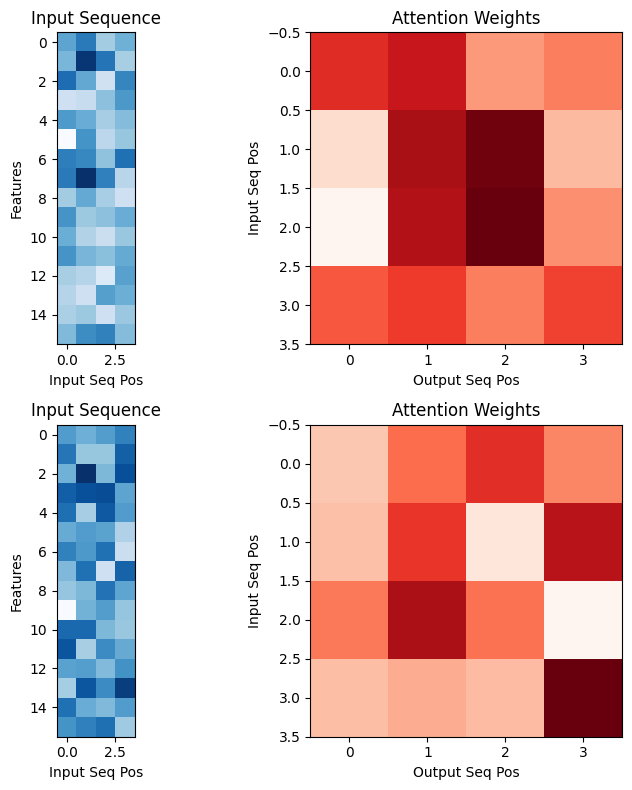

In [65]:

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers for query, key, and value projections
        self.q_proj = nn.Linear(input_dim, embed_dim)
        self.k_proj = nn.Linear(input_dim, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)

        # Linear layer for combining heads
        self.out_proj = nn.Linear(embed_dim, input_dim)

    def forward(self, x):
        batch_size = x.size(0)

        # Projections for query, key, and value
        # (batch_size, seq_len, embed_dim)
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Split into multiple heads
        # (batch_size, num_heads, seq_len, head_dim)
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute attention scores
        # (batch_size, num_heads, query_len, key_len)
        attn_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        # Compute attention output
        # (batch_size, num_heads, query_len, head_dim)
        attn_output = torch.matmul(attn_weights, v)

        # Concatenate heads and apply output projection
        # (batch_size, query_len, embed_dim)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.embed_dim)
        output = self.out_proj(attn_output)

        return output,attn_weights


# Create a dummy input tensor
batch_size = 2
seq_len = 4
input_dim = 16
embed_dim = 32
num_heads = 4

x = torch.randn(batch_size, seq_len, input_dim)

# Create a Multi-Head Attention instance
attn = MultiHeadAttention(input_dim, embed_dim, num_heads)

# Pass the input through the Multi-Head Attention layer
atten_output,attn_weights = attn(x)

print("Input shape:", x.shape)
print("Attention Output shape:", atten_output.shape)
print("Attention Weight shape:", attn_weights.shape)


visualize_attention_with_input_output(x, atten_output, attn_weights)

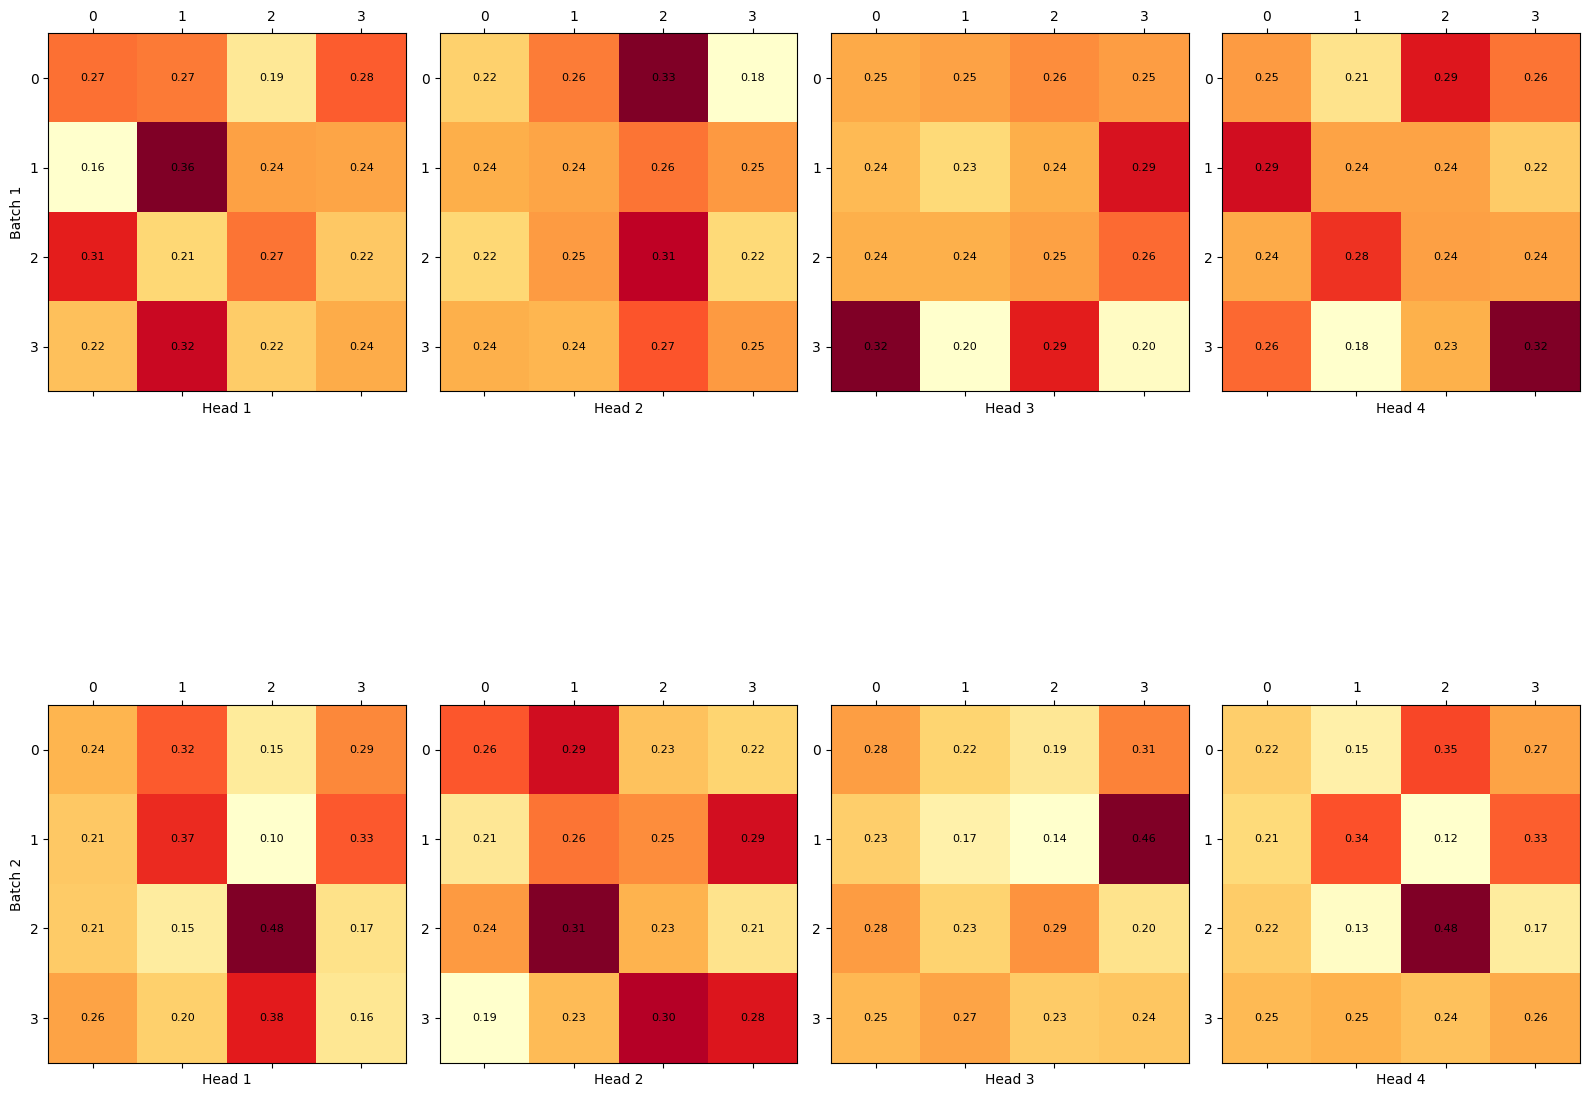

In [35]:
visualize_attention_weights(batch_size,num_heads,attn_weights)

#Transformer-XL Attention:
The Transformer-XL Attention is an extension of the self-attention mechanism that introduces a recurrence mechanism and relative positional encodings. This attention mechanism is particularly useful for capturing longer-term dependencies, which is crucial for tasks like language modeling and text generation.

Input shape: torch.Size([2, 4, 16])
Attention Output shape: torch.Size([2, 4, 16])
Attention Weight shape: torch.Size([2, 4, 4, 4])


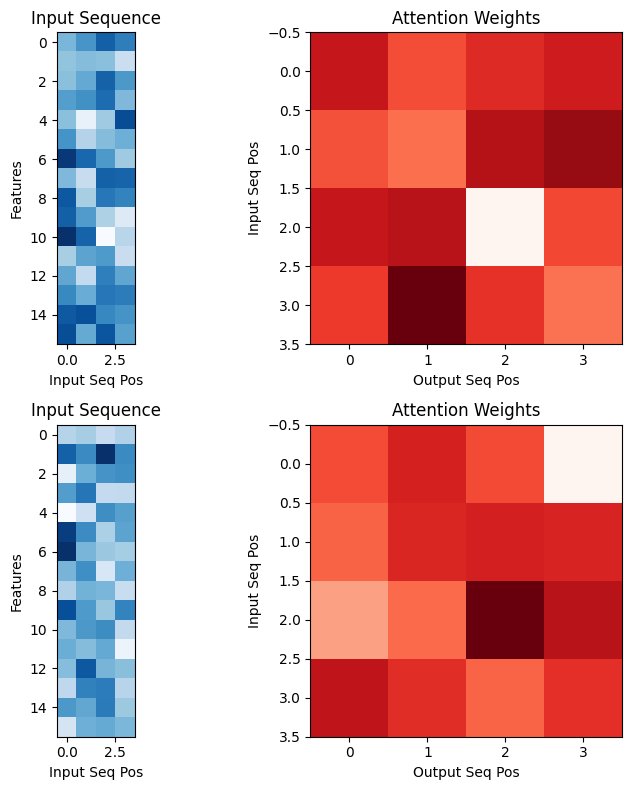

In [86]:
import torch
import torch.nn as nn
import math

class TransformerXLAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super(TransformerXLAttention, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.dropout = nn.Dropout(0.1)

        self.q_proj = nn.Linear(input_dim, embed_dim)
        self.k_proj = nn.Linear(input_dim, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)
        self.r_proj = nn.Linear(embed_dim, embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)

    def split_heads(self, x):
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)

    def merge_heads(self, x):
        batch_size, num_heads, seq_len, head_dim = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(batch_size, seq_len, num_heads * head_dim)

    def forward(self, x, mask=None, pos_emb=None):
        batch_size, seq_len, _ = x.size()

        # Compute query, key, and value projections
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Split into multiple heads
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Compute relative positional embeddings
        if pos_emb is not None:
            q_pos_emb = self.r_proj(pos_emb)
            q_pos_emb = self.split_heads(q_pos_emb)
            q = q + q_pos_emb

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = nn.Softmax(dim=-1)(scores)
        attn_weights = self.dropout(attn_weights)

        # Compute attended output
        output = torch.matmul(attn_weights, v)
        output = self.merge_heads(output)
        output = self.o_proj(output)

        return output, attn_weights

# Create dummy input tensors
batch_size = 2
seq_len = 4
input_dim = 16
embed_dim = 32
num_heads = 4

x = torch.randn(batch_size, seq_len, input_dim)

# Create a Transformer-XL Attention instance
attn = TransformerXLAttention(input_dim, embed_dim, num_heads)

# Pass the input through the Transformer-XL Attention layer
atten_output, attn_weights = attn(x)

print("Input shape:", x.shape)
print("Attention Output shape:", atten_output.shape)
print("Attention Weight shape:", attn_weights.shape)

visualize_attention_with_input_output(x, atten_output, attn_weights)

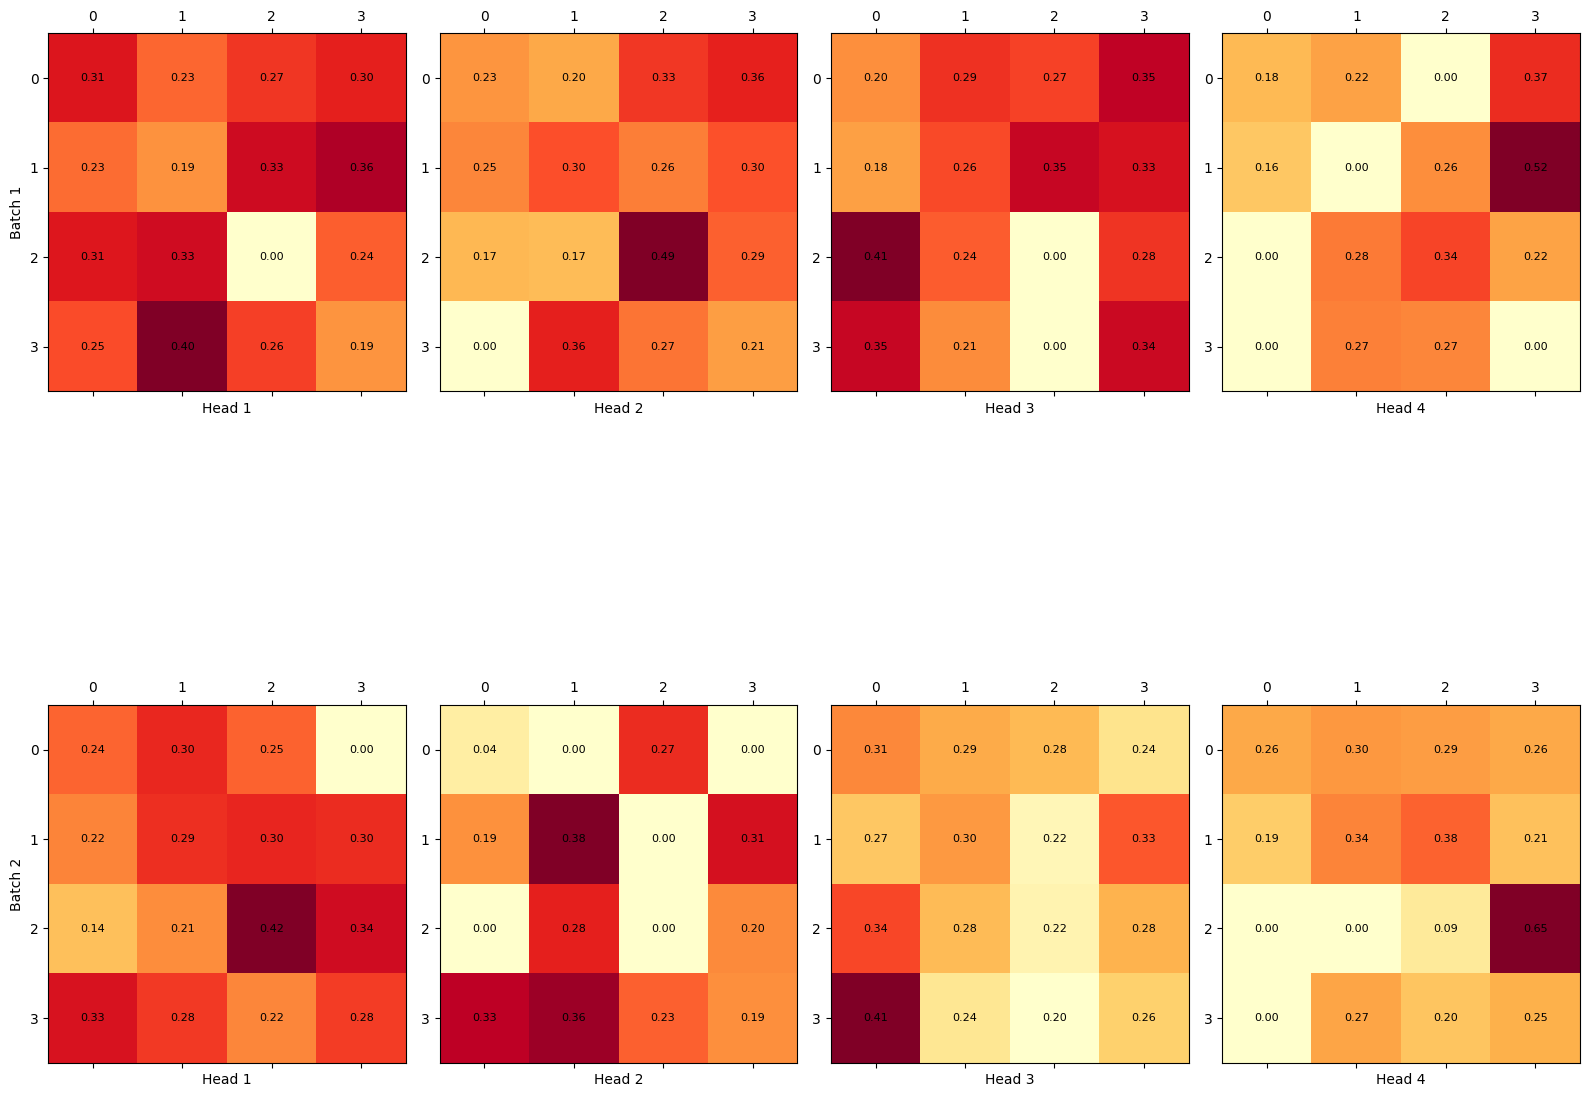

In [87]:
visualize_attention_weights(batch_size,num_heads,attn_weights)

#Self-Attention:
Self-attention is a crucial component of the Transformer architecture, which has become the backbone of many state-of-the-art NLP models and LLMs, such as BERT, GPT, and their variants. Self-attention allows the model to capture long-range dependencies within the input sequence, which is particularly important for tasks like language understanding and generation.

    Input(x):
(batch_size, seq_len, input_dim)

    Query(q), Key(k), Value(v) Projections:
(batch_size, seq_len, embed_dim)

    Split into Multiple Heads: q, k, and v are reshaped to
  (batch_size, num_heads, seq_len, head_dim)

    Attention Scores/Weights:
    attn_weights has the same dimensions as attn_scores as attn_weights = softmx(attn_scores)
  (batch_size, num_heads, seq_len, seq_len)

    Attention Output: attn_output has dimensions
  (batch_size, num_heads, seq_len, head_dim)

    Concatenate Heads and Apply Output Projection: attn_output is first reshaped to
  (batch_size, seq_len, embed_dim)

    and after applying the output projection, output has dimensions
  (batch_size, seq_len, input_dim)

Input shape: torch.Size([2, 10, 8])
Attention Output shape: torch.Size([2, 10, 8])
Attention Weight shape: torch.Size([2, 4, 10, 10])


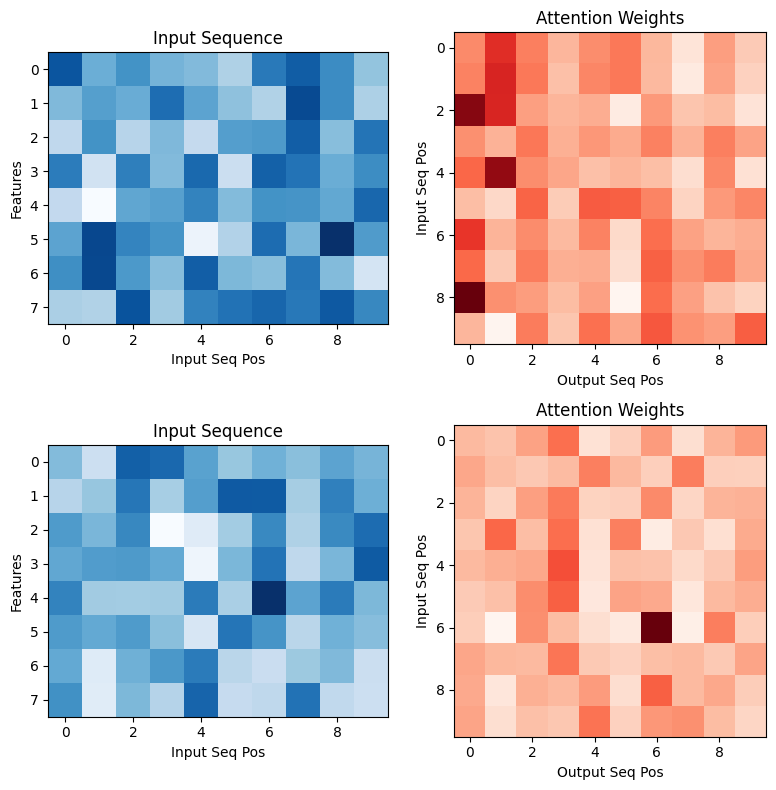

In [40]:
import torch
import torch.nn as nn


class SelfAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(input_dim, embed_dim)
        self.k_proj = nn.Linear(input_dim, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, input_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()  # (batch_size, seq_len, input_dim)

        # Projections for query, key, and value
        q = self.q_proj(x)  # (batch_size, seq_len, embed_dim)
        k = self.k_proj(x)  # (batch_size, seq_len, embed_dim)
        v = self.v_proj(x)  # (batch_size, seq_len, embed_dim)

        # Split into multiple heads
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, head_dim)

        # Compute attention scores
        attn_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)
        attn_weights = torch.softmax(attn_scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)

        # Compute attention output
        attn_output = torch.matmul(attn_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, self.embed_dim)  # (batch_size, seq_len, embed_dim)
        output = self.out_proj(attn_output)  # (batch_size, seq_len, input_dim)

        return output, attn_weights

# Example usage
batch_size = 2
seq_len = 10
input_dim = 8
embed_dim = 16 # head_dim = embed_dim // num_heads must be > 0 ideally even
num_heads = 4

x = torch.randn(batch_size, seq_len, input_dim)

attn = SelfAttention(input_dim, embed_dim, num_heads)
atten_output, attn_weights = attn(x)

print("Input shape:", x.shape)
print("Attention Output shape:", atten_output.shape)
print("Attention Weight shape:", attn_weights.shape)

visualize_attention_with_input_output(x, atten_output, attn_weights)


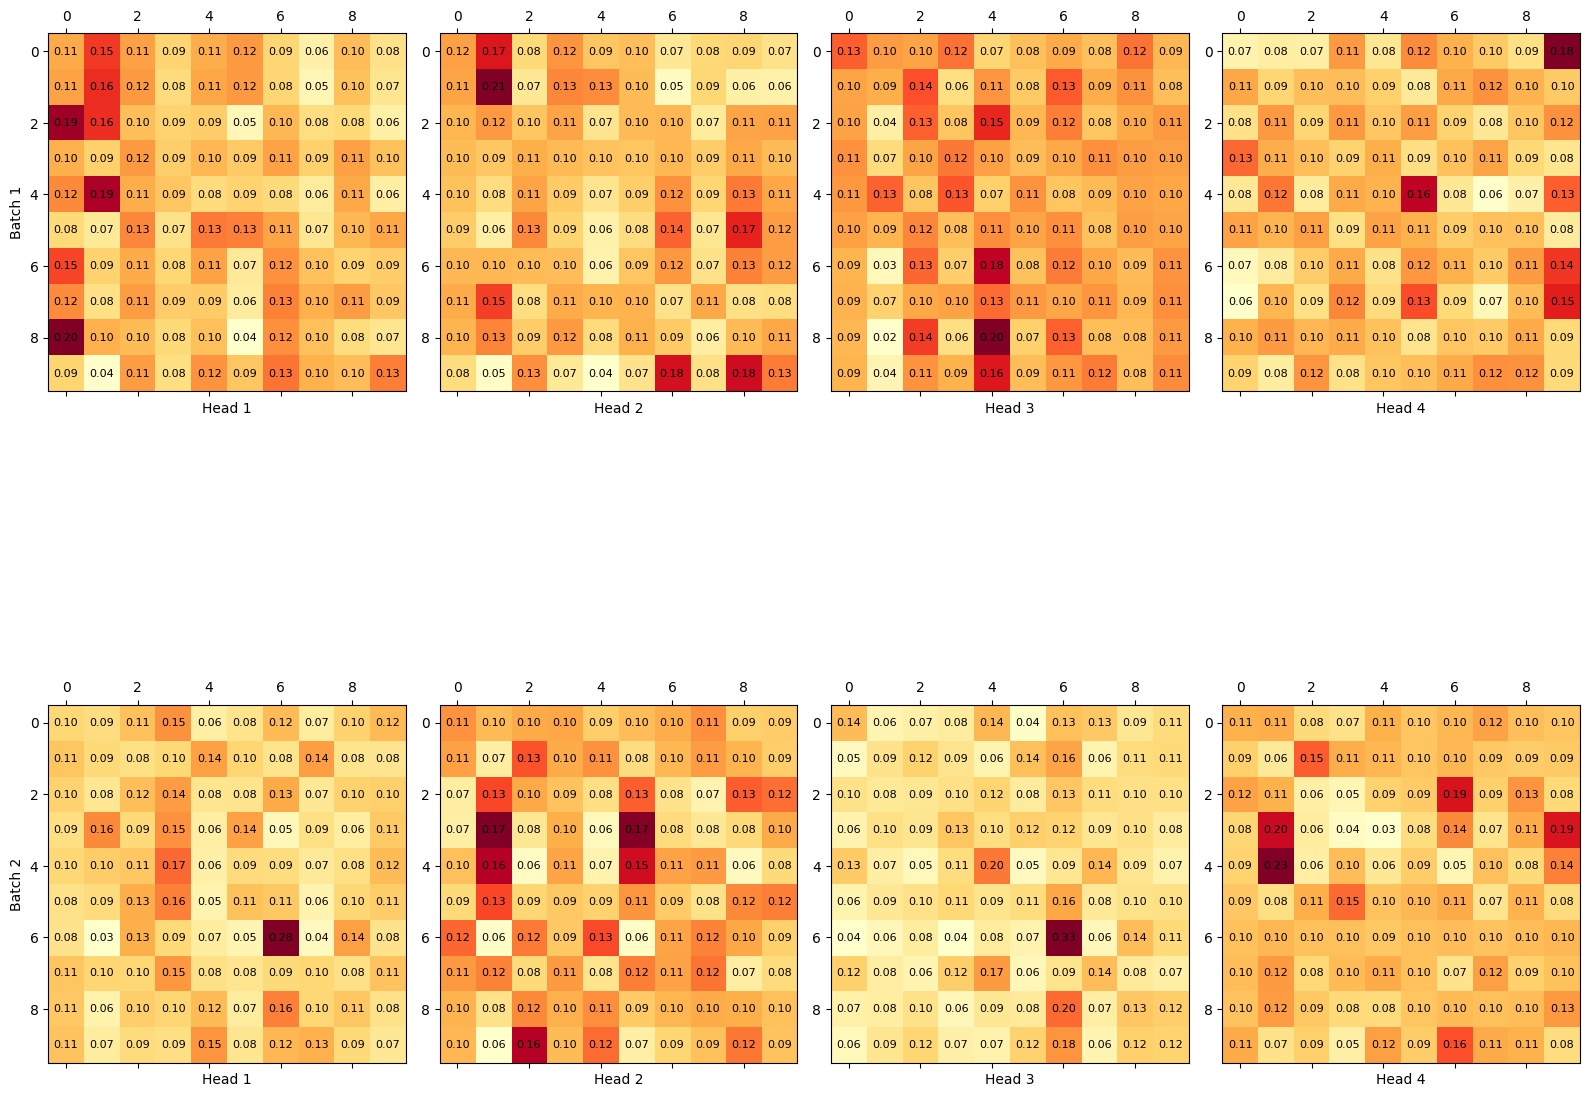

In [41]:
visualize_attention_weights(batch_size,num_heads,attn_weights)

#Scaled Dot-Product Attention:
Introduced in the original Transformer paper, the Scaled Dot-Product Attention is the core attention mechanism used in the self-attention and multi-head attention layers. It scales the dot product of the query and key vectors by the square root of the key dimension, preventing the softmax function from saturating and allowing for more stable training.

Input Shape: torch.Size([2, 10, 16])
Output Shape: torch.Size([2, 10, 16])
Attention Weights Shape: torch.Size([2, 4, 10, 10])


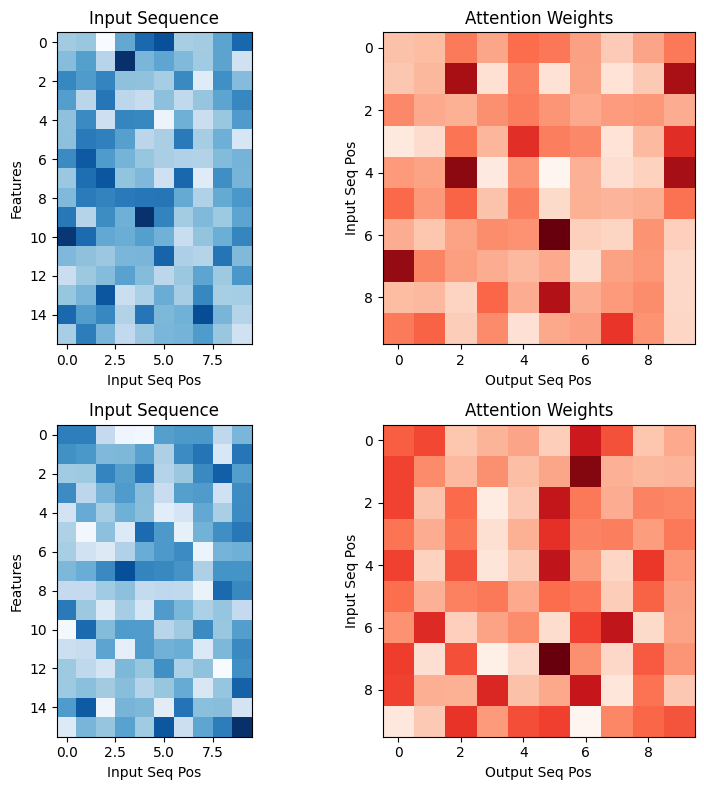

In [42]:
import torch
import torch.nn as nn

class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_dim,num_heads):
        super(ScaledDotProductAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.d_k = head_dim
        self.d_v = head_dim

        self.w_q = nn.Linear(embed_dim, self.d_k * num_heads, bias=False)
        self.w_k = nn.Linear(embed_dim, self.d_k * num_heads, bias=False)
        self.w_v = nn.Linear(embed_dim, self.d_v * num_heads, bias=False)


    def forward(self, x, mask=None):
        # Input dimensions:
        # x: (batch_size, seq_len, d_model)
        # mask: (batch_size, 1, seq_len, seq_len) (optional)

        batch_size, seq_len, _ = x.size()

        # Compute query, key, and value tensors
        q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_v).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)
        # scores: (batch_size, n_heads, query_len, key_len)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = nn.Softmax(dim=-1)(scores)
        # attn_weights: (batch_size, n_heads, query_len, key_len)

        output = torch.matmul(attn_weights, v)
        # output: (batch_size, n_heads, query_len, d_v)

        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # output: (batch_size, query_len, n_heads * d_v)

        return output, attn_weights

# Sample input dimensions
batch_size = 2
seq_len = 10
embed_dim = 16
num_heads = 4

# Create dummy input tensor
x = torch.randn(batch_size, seq_len, embed_dim)

# Create an instance of the ScaledDotProductAttention module
attention = ScaledDotProductAttention(embed_dim, num_heads)

# Apply the Scaled Dot-Product Attention
output, attn_weights = attention(x)

print("Input Shape:", x.shape)
print("Output Shape:", output.shape)
print("Attention Weights Shape:", attn_weights.shape)

visualize_attention_with_input_output(x, atten_output, attn_weights)

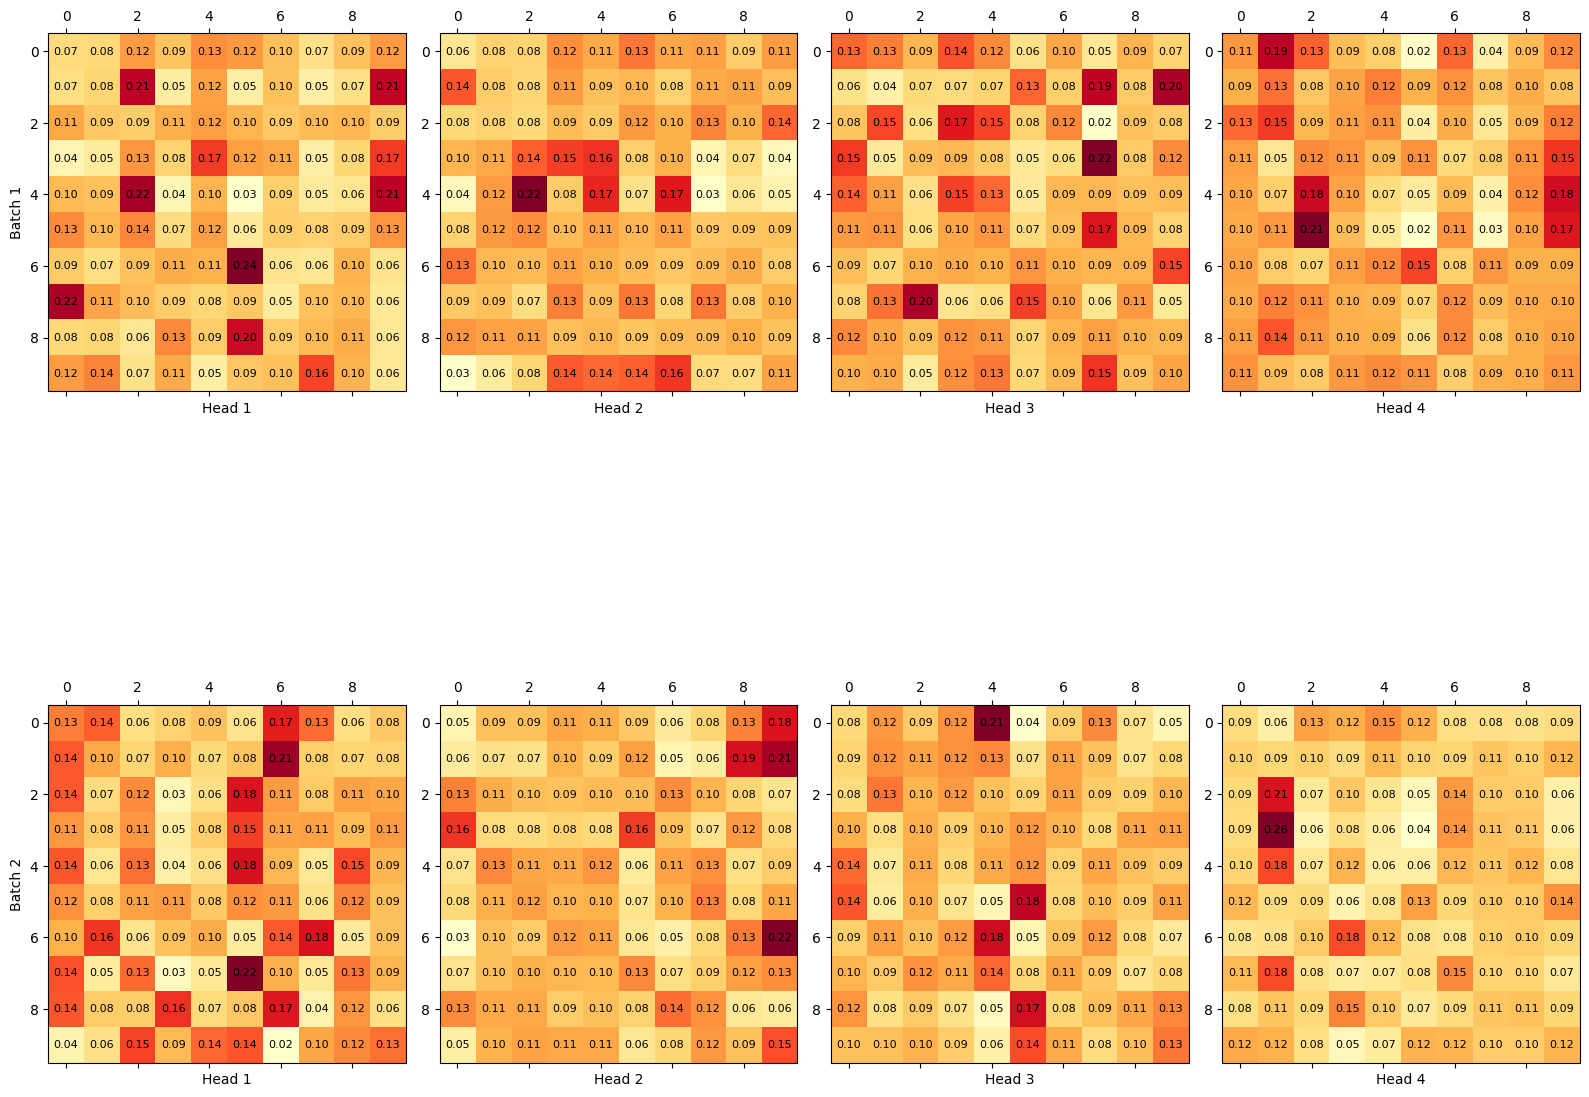

In [43]:
visualize_attention_weights(batch_size,num_heads,attn_weights)